# Length-of-stay (LOS) prediction in hospitals at time of admission

# 1. Project Overview

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

In [2]:
# Loading Admissions data into dataframe
admissions = pd.read_csv('F:/SEMESTER 3/DAB 304 - Healthcare Analytics\MIMIC 3/mimic-iii-clinical-database-1.4 - CSV/ADMISSIONS.csv')

# Loading Patients data into dataframe 
patients = pd.read_csv('F:/SEMESTER 3/DAB 304 - Healthcare Analytics\MIMIC 3/mimic-iii-clinical-database-1.4 - CSV/PATIENTS.csv')

# Loading Diagnosis data into dataframe
diagnosis = pd.read_csv('F:/SEMESTER 3/DAB 304 - Healthcare Analytics\MIMIC 3/mimic-iii-clinical-database-1.4 - CSV/DIAGNOSES_ICD.csv')

# Loading Intensive Care Unit (ICU) data into dataframe
icu = pd.read_csv('F:/SEMESTER 3/DAB 304 - Healthcare Analytics\MIMIC 3/mimic-iii-clinical-database-1.4 - CSV/ICUSTAYS.csv')

# 2. Data Exploration and Preprocessing

# 2.1 ADMISSIONS.csv

In this section, we will explore the 'ADMISSIONS' table of the MIMIC-III dataset.

The ADMISSIONS table gives information regarding a patient’s admission to the hospital. Since each unique hospital visit for a patient is assigned a unique HADM_ID, the ADMISSIONS table can be considered as a definition table for HADM_ID. Information available includes timing information for admission and discharge, demographic information, the source of the admission, and so on. 
**SOURCE:** [*MIMIC*](https://mimic.mit.edu/docs/iii/tables/admissions/)

In [3]:
# View Admissions Dataframe
admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [4]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                58976 non-null  int64 
 1   SUBJECT_ID            58976 non-null  int64 
 2   HADM_ID               58976 non-null  int64 
 3   ADMITTIME             58976 non-null  object
 4   DISCHTIME             58976 non-null  object
 5   DEATHTIME             5854 non-null   object
 6   ADMISSION_TYPE        58976 non-null  object
 7   ADMISSION_LOCATION    58976 non-null  object
 8   DISCHARGE_LOCATION    58976 non-null  object
 9   INSURANCE             58976 non-null  object
 10  LANGUAGE              33644 non-null  object
 11  RELIGION              58518 non-null  object
 12  MARITAL_STATUS        48848 non-null  object
 13  ETHNICITY             58976 non-null  object
 14  EDREGTIME             30877 non-null  object
 15  EDOUTTIME             30877 non-null

In [5]:
print('Dataset has {} number of unique admission events.'.format(admissions['HADM_ID'].nunique()))
print('Dataset has {} number of unique patients.'.format(admissions['SUBJECT_ID'].nunique()))

Dataset has 58976 number of unique admission events.
Dataset has 46520 number of unique patients.


# 2.1.1 Calculating Length-Of-Stay (LOS)

Patient Length-Of-Stay (LOS) can be calculated by subtracting the patient admission time from the discharge time. 

In [6]:
# Converting patirnt admission time and discharge time to datetime type
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])

In [7]:
# Calculating LOS in 'days' through difference of admission time and discharge time
admissions['LOS'] = (admissions['DISCHTIME'] - admissions['ADMITTIME']).dt.total_seconds()/86400

In [8]:
# Veiw LOS
admissions[['ADMITTIME', 'DISCHTIME', 'LOS']].head()

,ADMITTIME,DISCHTIME,LOS
0,2196-04-09 12:26:00,2196-04-10 15:54:00,1.144444
1,2153-09-03 07:15:00,2153-09-08 19:10:00,5.496528
2,2157-10-18 19:34:00,2157-10-25 14:00:00,6.768056
3,2139-06-06 16:14:00,2139-06-09 12:48:00,2.856944
4,2160-11-02 02:06:00,2160-11-05 14:55:00,3.534028


# # 2.1.2 Cleaning Length-Of-Stay (LOS)

In [9]:
admissions['LOS'].describe()

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

### Dropping negative values in our target variable LOS

We can drop negative LOS as according to the MIMIC-III data dictionary, Organ donor accounts are sometimes created for patients who died in the hospital. These are distinct hospital admissions with very short, sometimes negative lengths of stay. Furthermore, their DEATHTIME is frequently the same as the earlier patient admission’s DEATHTIME.

For our analysis, we do not want to include organ donors, as they are patients who are already dead and do not need immediate assistance or have to deal with long waiting times.

In [10]:
# Let's view records with negative LOS values
admissions[admissions['LOS'] < 0]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS
425,534,417,102633,2177-03-23 16:17:00,2177-03-23 07:20:00,2177-03-23 07:20:00,URGENT,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,NaN,NaN,ORGAN DONOR ACCOUNT,1,1,-0.372917
456,237,181,102631,2153-10-12 09:49:00,2153-10-12 06:29:00,2153-10-12 06:29:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,NaN,PROTESTANT QUAKER,MARRIED,WHITE,2153-10-12 06:23:00,2153-10-12 07:45:00,DISSECTING ANEURYSIM,1,1,-0.138889
692,644,516,187482,2197-07-31 20:18:00,2197-07-31 01:10:00,2197-07-31 01:10:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,JEWISH,WIDOWED,UNKNOWN/NOT SPECIFIED,2197-07-31 11:31:00,2197-07-31 14:35:00,RESPIRATORY DISTRESS,1,0,-0.797222
1911,1640,1334,138015,2137-09-02 14:43:00,2137-09-02 12:00:00,2137-09-02 12:00:00,NEWBORN,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,NaN,PROTESTANT QUAKER,NaN,WHITE,NaN,NaN,NEWBORN,1,1,-0.113194
1970,1699,1381,181430,2189-01-02 14:25:00,2189-01-02 12:00:00,2189-01-02 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,UNOBTAINABLE,MARRIED,WHITE,2189-01-02 10:31:00,2189-01-02 15:56:00,STROKE;TELEMETRY,1,1,-0.100694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57233,57980,96810,165589,2103-09-25 20:38:00,2103-09-25 12:00:00,2103-09-25 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,RUSS,UNOBTAINABLE,WIDOWED,WHITE,2103-09-25 19:27:00,2103-09-25 21:37:00,CARDIAC ARREST,1,1,-0.359722
57559,58635,98943,193747,2164-11-14 20:03:00,2164-11-14 12:00:00,2164-11-14 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,UNOBTAINABLE,MARRIED,WHITE,2164-11-14 18:24:00,2164-11-14 20:54:00,INTRACRANIAL HEMORRHAGE,1,1,-0.335417
57902,58720,99207,191004,2143-07-06 19:59:00,2143-07-06 12:00:00,2143-07-06 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,ENGL,CATHOLIC,DIVORCED,WHITE,2143-07-06 19:30:00,2143-07-06 20:05:00,GSW L. CHEST WALL & ABDOMEN,1,1,-0.332639
58346,55950,90642,101946,2122-04-24 14:36:00,2122-04-24 12:00:00,2122-04-24 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,MARRIED,UNABLE TO OBTAIN,NaN,NaN,ST-SEGMENT ELEVATION MYOCARDIAL INFARCTION\CATH,1,1,-0.108333


In [11]:
# Dropping negative LOS
admissions = admissions[admissions['LOS'] > 0]

### Checking for outliers in our target variable LOS

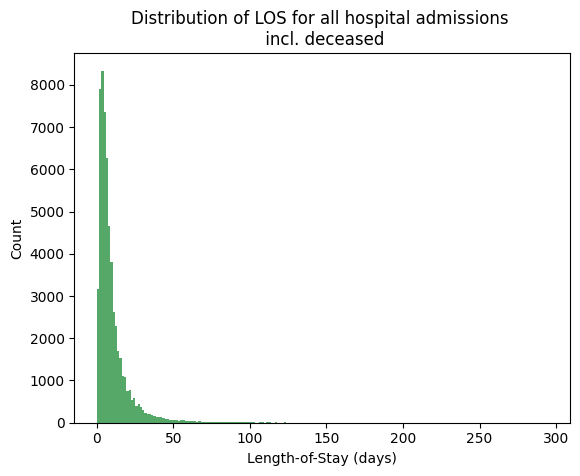

In [12]:
# Plotting LOS Distribution
plt.hist(admissions['LOS'], bins=200, color = '#55a868')
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show()

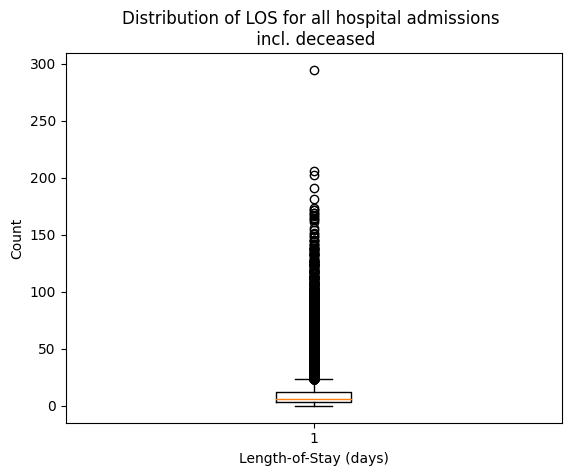

In [13]:
# Plotting a Boxplot for LOS
plt.boxplot(admissions['LOS'])
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show()

In [14]:
admissions['LOS'].describe()

count    58878.000000
mean        10.151266
std         12.459774
min          0.001389
25%          3.755556
50%          6.489583
75%         11.805556
max        294.660417
Name: LOS, dtype: float64

In [15]:
# Calculating number of cases of patients with LOS > 30
len(admissions[(admissions.LOS > 30)])

3064

Clearly we can see that there are a lot of outliers in our target variable Length-of-Stay (LOS). In medical field these outliers could mean a few exceptional chronic cases, where a patient was admitted for over a month.

**The number of cases over 30 days of LOS is 3064 (5.2 %) out of 58878**. We safely remove these outliers as they will certainly hamper the performance of our prediction model.

In [16]:
# Dropping records with LOS > 30
admissions = admissions[admissions['LOS'] <= 30]

In [17]:
len(admissions)

55814

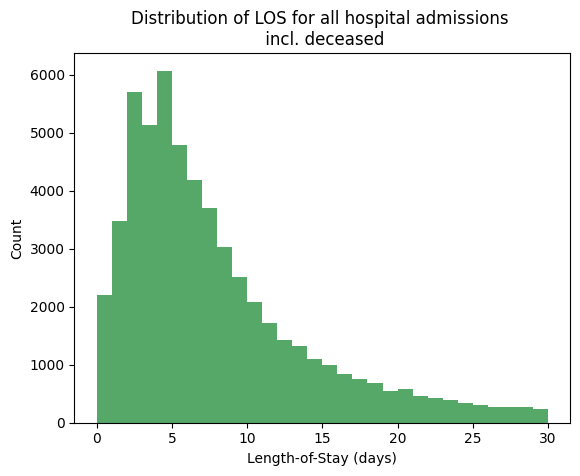

In [18]:
# Plotting LOS Distribution again
plt.hist(admissions['LOS'], bins=30, color = '#55a868')
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show()

In [19]:
# Dropping redundant columns that is not part of our analysis
admissions.drop(columns=['DISCHTIME', 'ROW_ID', 
                'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG',
                'HAS_CHARTEVENTS_DATA'], inplace=True)

# 2.1.3 Indentifying 'Deceased' patients to exclude them from our analysis

Patients who died in the hospital needs to be removed from the DataFrame because technically, they never "lived" while they were being discharged from the hospital.

This will affect our LOS result as LOS for this group will be shorter due to the uncertain nature of death.

In [20]:
# Creating a new column 'DECEASED' to mark admissions with deathtime values
admissions['DECEASED'] = admissions['DEATHTIME'].notnull().map({True:1, False:0})

In [21]:
print("{} of {} patients died in the hospital".format(admissions['DECEASED'].sum(), 
                                                     admissions['SUBJECT_ID'].nunique()))

5392 of 44440 patients died in the hospital


In [22]:
# Dropping records of deceased patients
admissions = admissions[admissions['DECEASED'] == 0]

In [23]:
# Lets Look at LOS statistics excluding dead patients
admissions['LOS'].describe()

count    50422.000000
mean         7.979426
std          6.042531
min          0.014583
25%          3.768056
50%          6.158681
75%         10.505382
max         29.990972
Name: LOS, dtype: float64

In [24]:
# Lets look at the mean and median lOS
print("Mean Length of stay is", round(admissions['LOS'].mean()))
print("Median Length of stay is", round(admissions['LOS'].median()))

Mean Length of stay is 8
Median Length of stay is 6


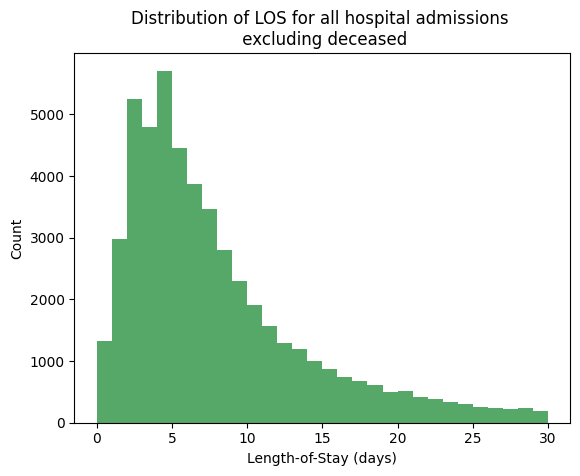

In [25]:
# Plotting LOS Distribution again
plt.hist(admissions['LOS'], bins=30, color = '#55a868')
plt.title('Distribution of LOS for all hospital admissions \n excluding deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show()

# 2.1.4 Ethnicity & Religion

Given the large number of categories in the 'ETHNICITY' column, our goal was to narrow the column down to a few broader categories i.e., WHITE, BLACK, HISPANIC, ASIAN and OTHER/UNKNOWN

Similarly, the number of 'RELIGION' categories can be narrowed down to being RELIGIOUS or not.

In [26]:
# Let's look at the ETHNICITY column
admissions['ETHNICITY'].value_counts()

WHITE                                                       35153
BLACK/AFRICAN AMERICAN                                       4751
UNKNOWN/NOT SPECIFIED                                        3566
HISPANIC OR LATINO                                           1498
ASIAN                                                        1338
OTHER                                                        1298
UNABLE TO OBTAIN                                              624
PATIENT DECLINED TO ANSWER                                    491
ASIAN - CHINESE                                               238
HISPANIC/LATINO - PUERTO RICAN                                213
BLACK/CAPE VERDEAN                                            180
WHITE - RUSSIAN                                               141
MULTI RACE ETHNICITY                                          112
BLACK/HAITIAN                                                  93
ASIAN - ASIAN INDIAN                                           77
WHITE - OT

In [27]:
# Compressing the number of ethnic categories
admissions['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
admissions['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
admissions['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
admissions['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
admissions['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
admissions['ETHNICITY'].loc[~admissions['ETHNICITY'].isin(admissions['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
admissions['ETHNICITY'].value_counts()

C:\Users\Siddhartha\AppData\Local\Temp\ipykernel_5668\1141224638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admissions['ETHNICITY'].loc[~admissions['ETHNICITY'].isin(admissions['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'


WHITE                     35437
OTHER/UNKNOWN              6258
BLACK/AFRICAN AMERICAN     5063
HISPANIC/LATINO            1897
ASIAN                      1767
Name: ETHNICITY, dtype: int64

In [28]:
# Lets define a function to plot a barplot against median LOS
def barplot_los_groupby(variable, size=(7,4)):
    ''' 
    Plot Median LOS by df categorical series name 
    '''
    results = admissions[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();
    
# Lets define a function to plot a boxplot against LOS
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    ''' 
    Boxplot of LOS by df categorical series name 
    '''
    results = admissions[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(admissions['LOS'].loc[admissions[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();

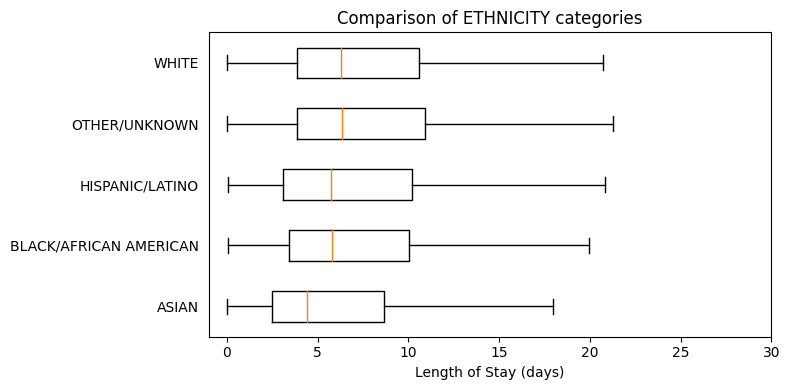

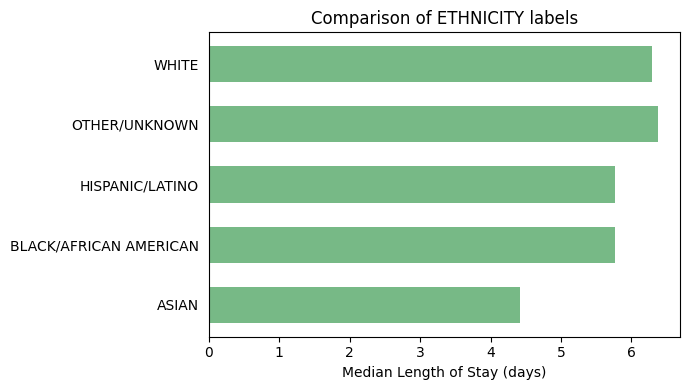

In [29]:
# Plotting ETHNICITY against LOS
boxplot_los_groupby('ETHNICITY')
barplot_los_groupby('ETHNICITY')

### Asians, interestingly, have the lowest median LOS

In [30]:
# Let's look at the RELIGION column
admissions['RELIGION'].value_counts()

CATHOLIC                  17732
NOT SPECIFIED             10337
UNOBTAINABLE               6652
PROTESTANT QUAKER          6163
JEWISH                     4486
OTHER                      2353
EPISCOPALIAN                665
GREEK ORTHODOX              396
CHRISTIAN SCIENTIST         368
BUDDHIST                    245
MUSLIM                      200
JEHOVAH'S WITNESS           116
UNITARIAN-UNIVERSALIST      102
HINDU                        97
7TH DAY ADVENTIST            69
ROMANIAN EAST. ORTH          63
BAPTIST                      18
HEBREW                       11
METHODIST                     5
LUTHERAN                      1
Name: RELIGION, dtype: int64

In [31]:
# Reducing the religion categories to terms of religious or not

admissions['RELIGION'].loc[~admissions['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

print(admissions['RELIGION'].value_counts())

print(admissions['RELIGION'].value_counts()[0]/len(admissions['RELIGION']))
print(admissions['RELIGION'].value_counts()[1]/len(admissions['RELIGION']))
print(admissions['RELIGION'].value_counts()[2]/len(admissions['RELIGION']))

RELIGIOUS        33433
NOT SPECIFIED    10337
UNOBTAINABLE      6652
Name: RELIGION, dtype: int64
0.6630637420173734
0.20500971798024673
0.1319265400023799


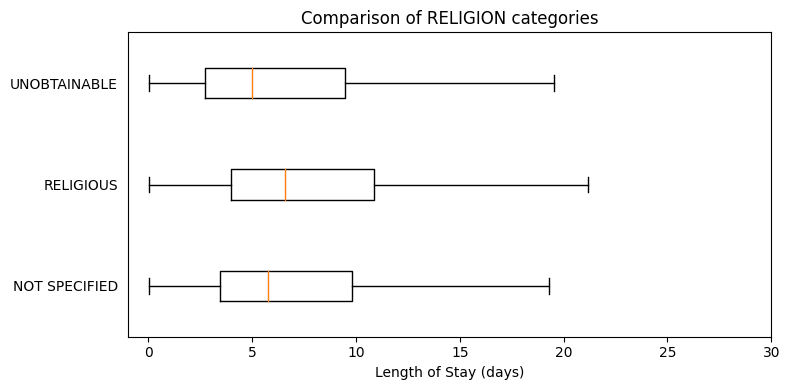

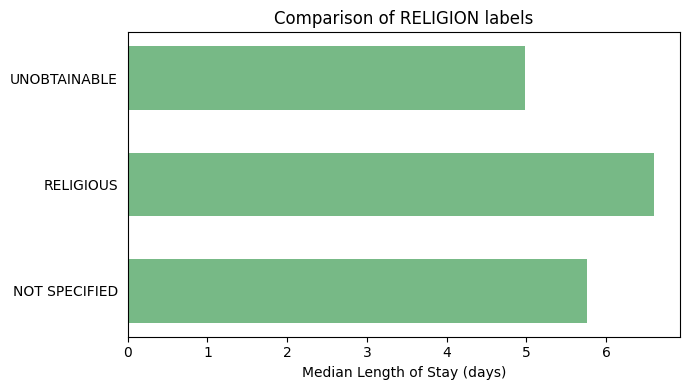

In [32]:
# Plotting RELIGION against LOS
boxplot_los_groupby('RELIGION')
barplot_los_groupby('RELIGION')

# 2.1.5 Marital status

In [33]:
# Let's look at the Marital status column
admissions['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              20784
SINGLE               11557
NaN                   8557
WIDOWED               5984
DIVORCED              2774
SEPARATED              489
UNKNOWN (DEFAULT)      262
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

In [34]:
# Filling missing values or NaN with 'UNKNOWN'
admissions['MARITAL_STATUS'] = admissions['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
admissions['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              20784
SINGLE               11557
UNKNOWN (DEFAULT)     8819
WIDOWED               5984
DIVORCED              2774
SEPARATED              489
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

In [35]:
# Combining 'MARRIED' and 'LIFE PARTNER' as 'MARRIED'
admissions['MARITAL_STATUS'].loc[admissions['MARITAL_STATUS'].isin(['LIFE PARTNER'])] = 'MARRIED'

# Combining 'DIVORCED' and 'SEPARATED' as 'DIVORCED'
admissions['MARITAL_STATUS'].loc[admissions['MARITAL_STATUS'].isin(['SEPARATED'])] = 'DIVORCED'

C:\Users\Siddhartha\AppData\Local\Temp\ipykernel_5668\2525776242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admissions['MARITAL_STATUS'].loc[admissions['MARITAL_STATUS'].isin(['LIFE PARTNER'])] = 'MARRIED'
C:\Users\Siddhartha\AppData\Local\Temp\ipykernel_5668\2525776242.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admissions['MARITAL_STATUS'].loc[admissions['MARITAL_STATUS'].isin(['SEPARATED'])] = 'DIVORCED'


In [36]:
admissions['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              20799
SINGLE               11557
UNKNOWN (DEFAULT)     8819
WIDOWED               5984
DIVORCED              3263
Name: MARITAL_STATUS, dtype: int64

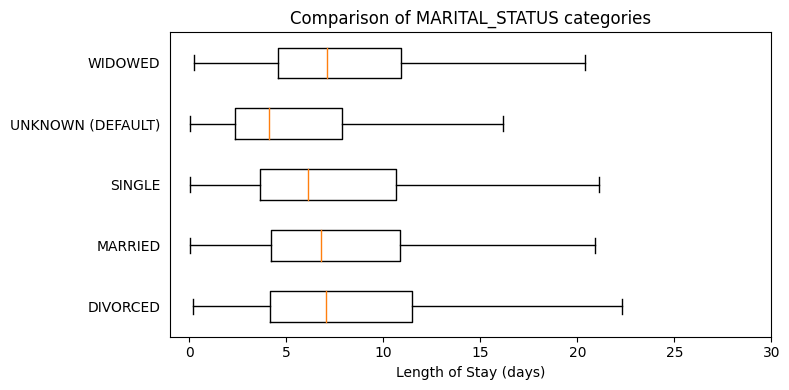

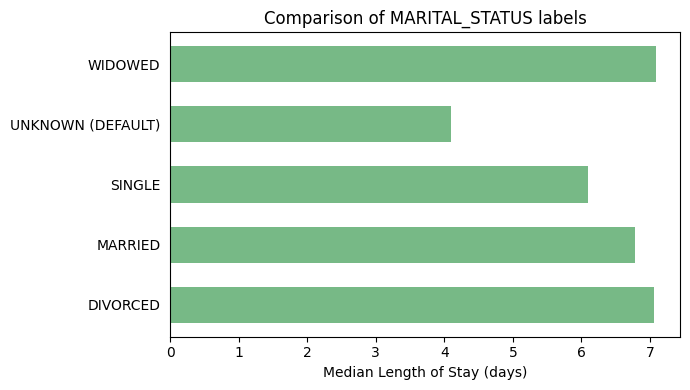

In [37]:
# Plotting Marital status against LOS
boxplot_los_groupby('MARITAL_STATUS')
barplot_los_groupby('MARITAL_STATUS')

# 2.1.6 Insurance

In [38]:
# Let's look at the INSURANCE column
admissions['INSURANCE'].value_counts()

Medicare      23456
Private       19905
Medicaid       4969
Government     1589
Self Pay        503
Name: INSURANCE, dtype: int64

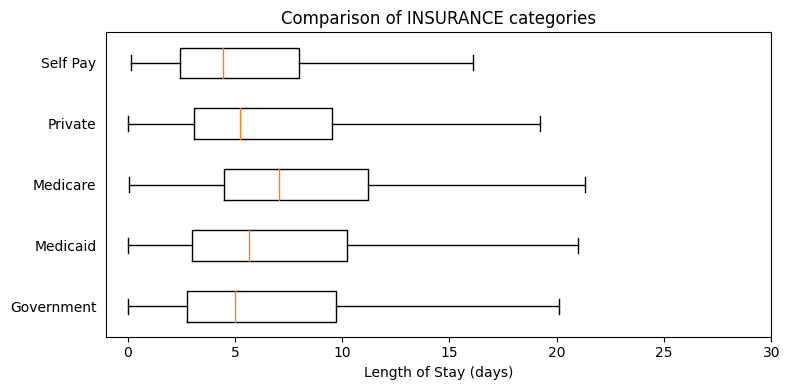

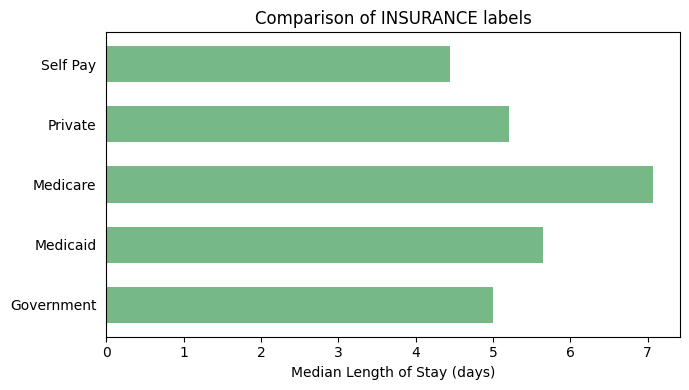

In [39]:
# Plotting INSURANCE against LOS
boxplot_los_groupby('INSURANCE')
barplot_los_groupby('INSURANCE')

### If a patient is 'Self-Pay', typically means they are not covered under any insurance. Here, Self-Pay patients have the lowest median LOS.

# 2.1.7 Admission Type

In [40]:
# Let's look at the INSURANCE column
admissions['ADMISSION_TYPE'].value_counts()

EMERGENCY    35036
ELECTIVE      7316
NEWBORN       6979
URGENT        1091
Name: ADMISSION_TYPE, dtype: int64

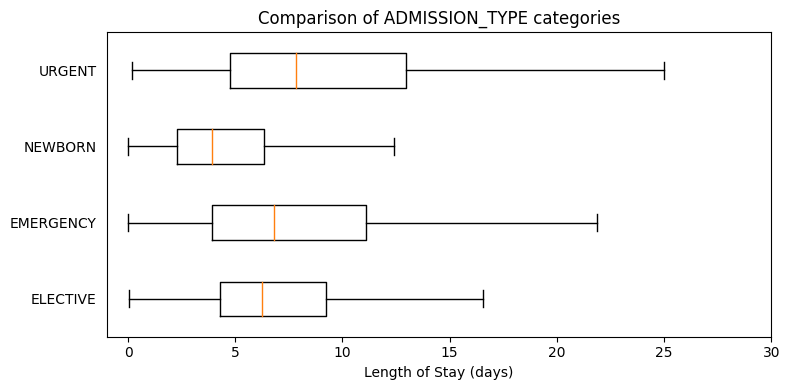

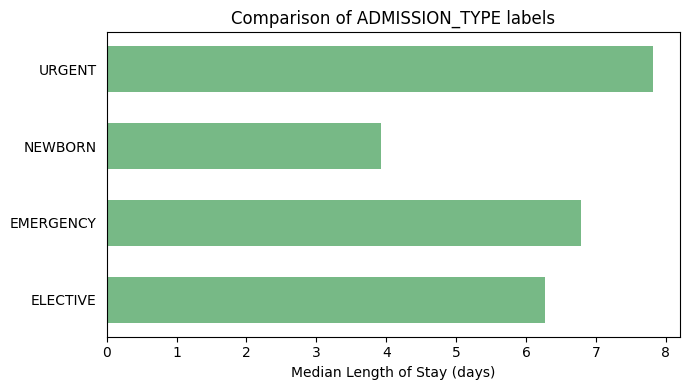

In [41]:
# Plotting ADMISSION TYPE against LOS
boxplot_los_groupby('ADMISSION_TYPE')
barplot_los_groupby('ADMISSION_TYPE')

### Newborns have the lowest median LOS. This mostly expected as the newborn deliveries are mostly well planned in advance and are discharged the mostly after 4 days.

# 2.2 DIAGNOSES_ICD.csv

In this section, we will explore the 'ICUSTAYS' table of the MIMIC-III dataset.

This table contains ICD diagnoses for patients, most notably ICD-9 diagnoses.
**SOURCE:** [*MIMIC*](https://mimic.mit.edu/docs/iii/tables/diagnoses_icd)


The International Classification of Diseases (ICD) is a globally used diagnostic tool for epidemiology, health management and clinical purposes. The ICD is maintained by the World Health Organization (WHO), which is the directing and coordinating authority for health within the United Nations System.[1] The ICD is originally designed as a health care classification system, providing a system of diagnostic codes for classifying diseases, including nuanced classifications of a wide variety of signs, symptoms, abnormal findings, complaints, social circumstances, and external causes of injury or disease. This system is designed to map health conditions to corresponding generic categories together with specific variations, assigning for these a designated code, up to six characters long. Thus, major categories are designed to include a set of similar diseases. **SOURCE:** [*Wikipedia*](https://en.wikipedia.org/wiki/International_Classification_of_Diseases)

# 2.2.1 ICD-9 Code - Feature Engineering

In [42]:
diagnosis.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [43]:
diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ROW_ID      651047 non-null  int64  
 1   SUBJECT_ID  651047 non-null  int64  
 2   HADM_ID     651047 non-null  int64  
 3   SEQ_NUM     651000 non-null  float64
 4   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


In [44]:
print('There are {} unique ICD9 codes in this dataset.'.format(diagnosis['ICD9_CODE'].value_counts().count()))

There are 6984 unique ICD9 codes in this dataset.


Using 6984 unique values as features for predicting LOS is impractical. Hence, we must categorise these diagnosis codes into more general categories. After thorough reserach into ICD9 codes, we found out that these codes can be arranged and organised into these following broader categories:

* List of ICD-9 codes 001–139: infectious and parasitic diseases
* List of ICD-9 codes 140–239: neoplasms
* List of ICD-9 codes 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
* List of ICD-9 codes 280–289: diseases of the blood and blood-forming organs
* List of ICD-9 codes 290–319: mental disorders
* List of ICD-9 codes 320–389: diseases of the nervous system and sense organs
* List of ICD-9 codes 390–459: diseases of the circulatory system
* List of ICD-9 codes 460–519: diseases of the respiratory system
* List of ICD-9 codes 520–579: diseases of the digestive system
* List of ICD-9 codes 580–629: diseases of the genitourinary system
* List of ICD-9 codes 630–679: complications of pregnancy, childbirth, and the puerperium
* List of ICD-9 codes 680–709: diseases of the skin and subcutaneous tissue
* List of ICD-9 codes 710–739: diseases of the musculoskeletal system and connective tissue
* List of ICD-9 codes 740–759: congenital anomalies
* List of ICD-9 codes 760–779: certain conditions originating in the perinatal period
* List of ICD-9 codes 780–799: symptoms, signs, and ill-defined conditions
* List of ICD-9 codes 800–999: injury and poisoning
* List of ICD-9 codes E and V codes: external causes of injury and supplemental classification








**SOURCE:** [*Wikipedia*](https://en.wikipedia.org/wiki/List_of_ICD-9_codes)



In [45]:
# Convering E and V codes to '999' as both E and V codes fall under broader category of injury, which is under code '999'
diagnosis['recode'] = diagnosis['ICD9_CODE']
diagnosis['recode'] = diagnosis['recode'][~diagnosis['recode'].str.contains("[a-zA-Z]").fillna(False)]
diagnosis['recode'].fillna(value='999', inplace=True)

In [46]:
diagnosis['recode'] = diagnosis['recode'].str.slice(start=0, stop=3, step=1)
diagnosis['recode'] = diagnosis['recode'].astype(int)

In [47]:
# ICD-9 Category Bins
icd9_bins = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diagnosis_dict = {0: 'D_INFECTIOUS', 1: 'D_NEOPLASMS', 2: 'D_ENDOCRINE', 3: 'D_BLOOD',
                  4: 'D_MENTAL', 5: 'D_NERVOUS', 6: 'D_CIRCULATORY', 7: 'D_RESPIRATORY',
                  8: 'D_DIGESTIVE', 9: 'D_GENITOURINARY', 10: 'D_PREGNANCY', 11: 'D_SKIN',
                  12: 'D_MUSCULAR', 13: 'D_CONGENITAL', 14: 'D_PRENATAL', 15: 'D_MISC',
                  16: 'D_INJURY', 17: 'D_MISC'}

# Re-coding in terms of integer
for x, y in enumerate(icd9_bins):
    diagnosis['recode'] = np.where(diagnosis['recode'].between(y[0], y[1]), 
            x, diagnosis['recode'])
    
# Converting 'recode' integer to category name using diagnosis_dict
diagnosis['recode'] = diagnosis['recode']
diagnosis['category'] = diagnosis['recode'].replace(diagnosis_dict)

In [48]:
# Veiw the new columns
diagnosis.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,recode,category
0,1297,109,172335,1.0,40301,6,D_CIRCULATORY
1,1298,109,172335,2.0,486,7,D_RESPIRATORY
2,1299,109,172335,3.0,58281,9,D_GENITOURINARY
3,1300,109,172335,4.0,5855,9,D_GENITOURINARY
4,1301,109,172335,5.0,4254,6,D_CIRCULATORY


There may be (and usually is) more than one diagnosis for each admission. There are quite often multiple diagnoses for a single category. As a result, we would need to create a dummy matrix that lists all of the diagnoses for each admission. And since each patient may have a different diagnosis for each admission, this should not be done on the SUBJECT ID.

In [49]:
# Creating a list of diagnosis category grouped under hospital admission ID
hadm_category_list = diagnosis.groupby('HADM_ID')['category'].apply(list).reset_index()
hadm_category_list.head()

,HADM_ID,category
0,100001,"[D_ENDOCRINE, D_NERVOUS, D_GENITOURINARY, D_DI..."
1,100003,"[D_DIGESTIVE, D_BLOOD, D_INFECTIOUS, D_DIGESTI..."
2,100006,"[D_RESPIRATORY, D_RESPIRATORY, D_RESPIRATORY, ..."
3,100007,"[D_DIGESTIVE, D_DIGESTIVE, D_INJURY, D_RESPIRA..."
4,100009,"[D_CIRCULATORY, D_INJURY, D_CIRCULATORY, D_END..."


In [50]:
# Convert list of diagnosis category into individual columns using get_dummies [Categorical Encoding]
hadm_category_item = pd.get_dummies(hadm_category_list['category'].apply(pd.Series).stack()).sum(level=0)
hadm_category_item.head()

C:\Users\Siddhartha\AppData\Local\Temp\ipykernel_5668\4168579682.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  hadm_category_item = pd.get_dummies(hadm_category_list['category'].apply(pd.Series).stack()).sum(level=0)


,D_BLOOD,D_CIRCULATORY,D_CONGENITAL,D_DIGESTIVE,D_ENDOCRINE,D_GENITOURINARY,D_INFECTIOUS,D_INJURY,D_MENTAL,D_MISC,D_MUSCULAR,D_NEOPLASMS,D_NERVOUS,D_PREGNANCY,D_PRENATAL,D_RESPIRATORY,D_SKIN
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0


In [51]:
# Let's join category_item back with HADM_ID
hadm_category_item = hadm_category_item.join(hadm_category_list['HADM_ID'], how="outer")
hadm_category_item.head()

,D_BLOOD,D_CIRCULATORY,D_CONGENITAL,D_DIGESTIVE,D_ENDOCRINE,D_GENITOURINARY,D_INFECTIOUS,D_INJURY,D_MENTAL,D_MISC,D_MUSCULAR,D_NEOPLASMS,D_NERVOUS,D_PREGNANCY,D_PRENATAL,D_RESPIRATORY,D_SKIN,HADM_ID
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1,100001
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,100003
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0,100006
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,100007
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0,100009


In [52]:
# Let's merge this to our main admissions dataframe
admissions = admissions.merge(hadm_category_item, how='inner', on='HADM_ID')

In [53]:
# Veiw admissions dataframe
admissions.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,D_INJURY,D_MENTAL,D_MISC,D_MUSCULAR,D_NEOPLASMS,D_NERVOUS,D_PREGNANCY,D_PRENATAL,D_RESPIRATORY,D_SKIN
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,4,1,0,0,0,1,0,0,0,0
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,...,1,0,0,0,0,1,0,0,0,0
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,...,3,0,0,0,1,1,0,1,0,0
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,0,0,0
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0,0,0,0,0,0,0,0,0,0


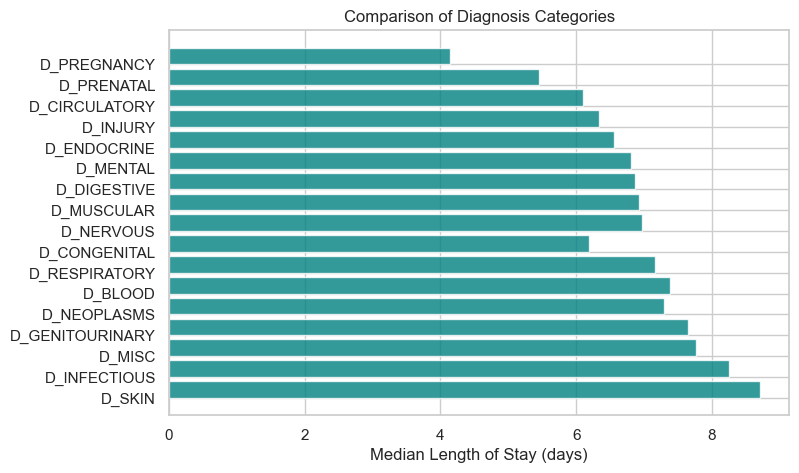

In [54]:
# Let's plot the median LOS across all the diagnosis categories
category_list = ['D_SKIN', 'D_INFECTIOUS',  'D_MISC', 'D_GENITOURINARY', 'D_NEOPLASMS', 'D_BLOOD', 'D_RESPIRATORY',
                 'D_CONGENITAL','D_NERVOUS', 'D_MUSCULAR', 'D_DIGESTIVE', 'D_MENTAL', 'D_ENDOCRINE', 'D_INJURY',
                 'D_CIRCULATORY', 'D_PRENATAL',  'D_PREGNANCY']

output = []
for z in category_list:
    output.append(admissions[[z, 'LOS']].groupby(z).median().reset_index().values[1][1])

sns.set(style="whitegrid")
# sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8,5))
ind = range(len(output))
ax.barh(ind, output, align='edge', color = 'teal', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(category_list)
ax.set_xlabel('Median Length of Stay (days)')
ax.tick_params(left=False, right=False, top=False) 
ax.set_title('Comparison of Diagnosis Categories'.format(z))
plt.show()

# 2.3 Patients.csv

In this section, we will explore the 'Patients' table of the MIMIC-III dataset.

This table contains DOB (Date of Birth) and gender information for patients.
**SOURCE:** [*MIMIC*](https://mimic.mit.edu/docs/iii/tables/patients)

Since we don’t have real-time data and the dates in the MIMIC dataset are anonymized into random future dates (such as year 2172). To derive the age from patient DOB, we will be calculating the difference between their ‘DOB’ and their first admission date.

In [55]:
patients.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [56]:
patients['GENDER'].value_counts()

M    26121
F    20399
Name: GENDER, dtype: int64

In [57]:
# Converting DOB to datetime format
patients['DOB'] = pd.to_datetime(patients['DOB'])

In [58]:
# Subsetting patients to columns required for our analysis
patients = patients[['SUBJECT_ID', 'DOB', 'GENDER']]
patients.head()

,SUBJECT_ID,DOB,GENDER
0,249,2075-03-13,F
1,250,2164-12-27,F
2,251,2090-03-15,M
3,252,2078-03-06,M
4,253,2089-11-26,F


In [59]:
# Merging patients data with our main admissions dataframe
admissions = admissions.merge(patients, how='inner', on='SUBJECT_ID')

# 2.3.1 Gender

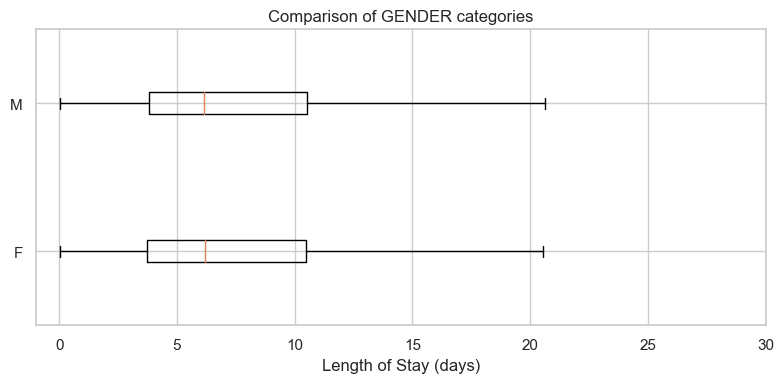

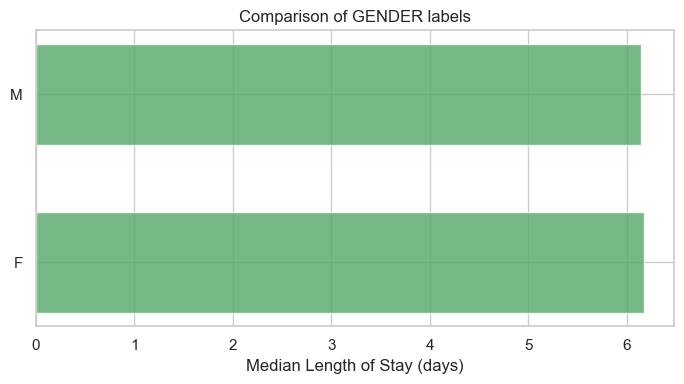

In [60]:
# Plotting GENDER against LOS
boxplot_los_groupby('GENDER')
barplot_los_groupby('GENDER')

Clearly from the plot, Males and Females have the same median Length of Stay.

# 2.3.2 Age - Feature Engineering

For calculating age, since we don’t have real-time data and the dates in the MIMIC dataset are anonymized into random future dates (such as year 2172). We will be calculating age by the difference between their ‘DOB’ and their first admission date (i.e., the earliest admission date across each subject ID).

In [61]:
# Calculating the earliest admission time for each patient
admission_time_min = admissions[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
admission_time_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
admission_time_min.head()

,SUBJECT_ID,ADMIT_MIN
0,2,2138-07-17 19:04:00
1,3,2101-10-20 19:08:00
2,4,2191-03-16 00:28:00
3,5,2103-02-02 04:31:00
4,6,2175-05-30 07:15:00


In [62]:
# Merging patients minimum admission time with our main admissions dataframe
admissions = admissions.merge(admission_time_min, how='inner', on='SUBJECT_ID')

In [63]:
# Viewing admissions
admissions.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,D_MUSCULAR,D_NEOPLASMS,D_NERVOUS,D_PREGNANCY,D_PRENATAL,D_RESPIRATORY,D_SKIN,DOB,GENDER,ADMIT_MIN
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,0,0,1,0,0,0,0,2131-05-07,F,2196-04-09 12:26:00
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,...,0,0,1,0,0,0,0,2082-07-17,M,2153-09-03 07:15:00
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,...,0,1,1,0,1,0,0,2082-07-17,M,2153-09-03 07:15:00
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,2100-05-31,M,2139-06-06 16:14:00
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0,0,0,0,0,0,0,2101-11-21,M,2160-11-02 02:06:00


In [64]:
# Coverting datetime to date to date format
admissions['DOB'] = pd.to_datetime(admissions['DOB']).dt.date

In [65]:
# Coverting datetime to date to date format
admissions['ADMIT_MIN'] = pd.to_datetime(admissions['ADMIT_MIN']).dt.date

In [66]:
# Age is calculated by finding the difference between minimum admission date and DOB
admissions['age'] = admissions.apply(lambda e: (e['ADMIT_MIN'] - e['DOB']).days/365, axis=1)
# admissions['age'] = np.where(admissions['age'] < 0, 90, admissions['age'])
# admissions['age'].isnull().sum()

In [67]:
# Rounding of Age to zero decimal places
admissions['age'] = admissions['age'].round(0)

In [68]:
admissions.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,D_NEOPLASMS,D_NERVOUS,D_PREGNANCY,D_PRENATAL,D_RESPIRATORY,D_SKIN,DOB,GENDER,ADMIT_MIN,age
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,0,1,0,0,0,0,2131-05-07,F,2196-04-09,65.0
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,...,0,1,0,0,0,0,2082-07-17,M,2153-09-03,71.0
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,...,1,1,0,1,0,0,2082-07-17,M,2153-09-03,71.0
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,2100-05-31,M,2139-06-06,39.0
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0,0,0,0,0,0,2101-11-21,M,2160-11-02,59.0


# 2.3.2 Age - Removing Outliers

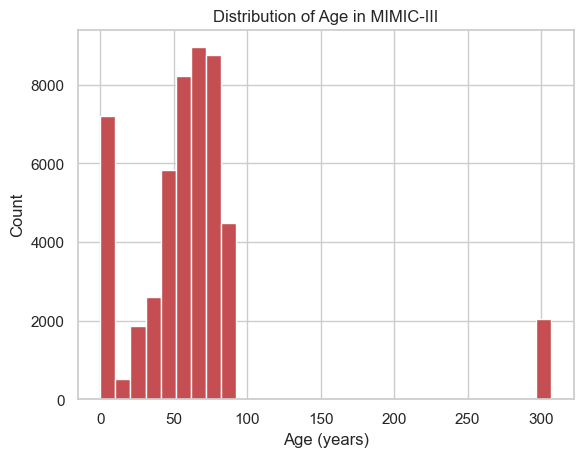

In [69]:
# Lets look at the distribution of Age
plt.hist(admissions['age'], bins=30, color='#c44e52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show();

### Clearly there are some outliers in age, as age cannot be 300+ years

In [70]:
admissions['age'].describe()

count    50422.000000
mean        62.369125
std         55.403796
min          0.000000
25%         42.000000
50%         60.000000
75%         75.000000
max        307.000000
Name: age, dtype: float64

In [71]:
admissions['age'].sort_values(ascending=False)

20492    307.0
25190    302.0
42702    300.0
29154    300.0
40500    300.0
         ...  
16000      0.0
29670      0.0
5740       0.0
5741       0.0
11608      0.0
Name: age, Length: 50422, dtype: float64

In [72]:
# Lets look at number of patients > 100
len(admissions[(admissions.age > 100)])

2042

In [73]:
# # Dropping patients with age > 100
admissions = admissions[admissions['age'] <= 100]

In [74]:
admissions['age'].describe()

count    48380.000000
mean        52.339128
std         26.739638
min          0.000000
25%         40.000000
50%         59.000000
75%         73.000000
max         89.000000
Name: age, dtype: float64

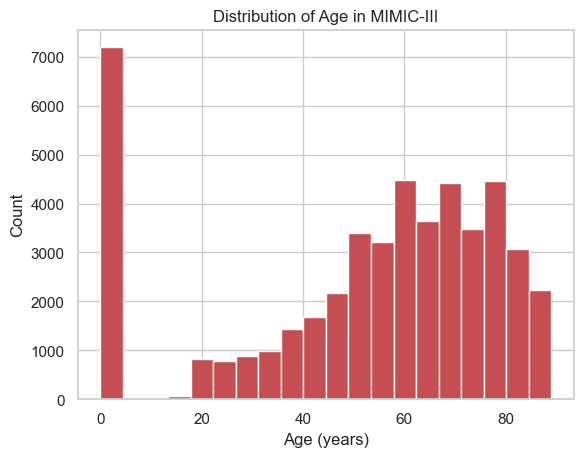

In [75]:
# Lets look at the distribution of Age again
plt.hist(admissions['age'], bins=20, color='#c44e52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show();

### From the age histogram, we can say that we have a fairly good distribution of patients across various age group, with high concentration of patients in the age group 0-5 because they are mostly new-born infants.

(1.0, 50.0)

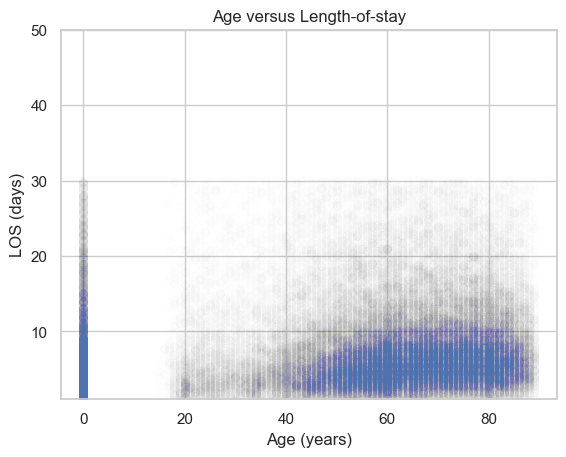

In [76]:
#Lets plot at scatter plot for Age against LOS

plt.scatter(admissions['age'], admissions['LOS'], alpha=0.005)
#plt.yscale('sqrt')
plt.ylabel('LOS (days)')
plt.xlabel('Age (years)')
plt.title('Age versus Length-of-stay')
plt.ylim(1, 50)

In [77]:
admissions['age_numerical'] = admissions['age']

In [78]:
# Lets covert age into categorical age groups for simplification of our analysis
age_bins = [(0, 15), (15, 25), (25, 65), (65, 100)]
for x, y in enumerate(age_bins):
    admissions['age'] = np.where(admissions['age'].between(y[0],y[1]), 
            x, admissions['age'])
    
age_dict = {0: 'child', 1: 'youth', 2: 'adult', 3: 'senior'}
admissions['age'] = admissions['age'].replace(age_dict)

In [79]:
# Lets count the number of patients across different age groups 
admissions.age.value_counts()

adult     21137
senior    18575
child      7200
youth      1468
Name: age, dtype: int64

In [80]:
admissions.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,D_NERVOUS,D_PREGNANCY,D_PRENATAL,D_RESPIRATORY,D_SKIN,DOB,GENDER,ADMIT_MIN,age,age_numerical
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,1,0,0,0,0,2131-05-07,F,2196-04-09,adult,65.0
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,...,1,0,0,0,0,2082-07-17,M,2153-09-03,senior,71.0
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,...,1,0,1,0,0,2082-07-17,M,2153-09-03,senior,71.0
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,2100-05-31,M,2139-06-06,adult,39.0
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0,0,0,0,0,2101-11-21,M,2160-11-02,adult,59.0


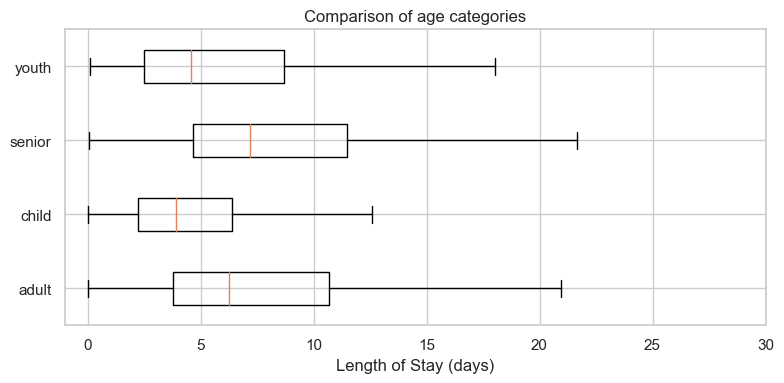

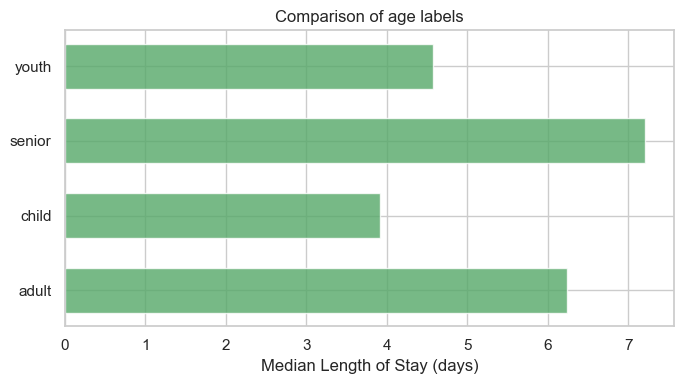

In [81]:
# Plotting AGE GROUP against LOS
boxplot_los_groupby('age')
barplot_los_groupby('age')

# 2.4 ICUSTAYS.csv

In [82]:
# Let looks at the icu dataframe
icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          61532 non-null  int64  
 1   SUBJECT_ID      61532 non-null  int64  
 2   HADM_ID         61532 non-null  int64  
 3   ICUSTAY_ID      61532 non-null  int64  
 4   DBSOURCE        61532 non-null  object 
 5   FIRST_CAREUNIT  61532 non-null  object 
 6   LAST_CAREUNIT   61532 non-null  object 
 7   FIRST_WARDID    61532 non-null  int64  
 8   LAST_WARDID     61532 non-null  int64  
 9   INTIME          61532 non-null  object 
 10  OUTTIME         61522 non-null  object 
 11  LOS             61522 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB


In [83]:
# Lets look at unique admission IDs
icu['HADM_ID'].nunique()

57786

In [84]:
# Lets look at the median LOS across different ICU units
icu.groupby('FIRST_CAREUNIT')['LOS'].median()

FIRST_CAREUNIT
CCU      2.19775
CSRU     2.15290
MICU     2.09550
NICU     0.80250
SICU     2.25220
TSICU    2.11150
Name: LOS, dtype: float64

### Based on above statistics, we can mainly reduce the ICU ward types to just 'ICU' and Non-ICU (or 'NICU')

In [85]:
# Coverting all values under 'FIRST_CAREUNIT' to ICU except for NICU
icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

In [86]:
icu['unit'] = icu['FIRST_CAREUNIT']
hadm_unit = icu.groupby('HADM_ID')['unit'].apply(list).reset_index()
hadm_unit.head()

,HADM_ID,unit
0,100001,[ICU]
1,100003,[ICU]
2,100006,[ICU]
3,100007,[ICU]
4,100009,[ICU]


In [87]:
icu['FIRST_CAREUNIT'].value_counts()

ICU     53432
NICU     8100
Name: FIRST_CAREUNIT, dtype: int64

In [88]:
# Creating a matrix for admission and ICU 
icu_matrix = pd.get_dummies(hadm_unit['unit'].apply(pd.Series).stack()).sum(level=0)
icu_matrix[icu_matrix >= 1] = 1
icu_matrix = icu_matrix.join(hadm_unit['HADM_ID'], how="outer")
icu_matrix.head()

C:\Users\Siddhartha\AppData\Local\Temp\ipykernel_5668\2606030451.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  icu_matrix = pd.get_dummies(hadm_unit['unit'].apply(pd.Series).stack()).sum(level=0)


,ICU,NICU,HADM_ID
0,1,0,100001
1,1,0,100003
2,1,0,100006
3,1,0,100007
4,1,0,100009


In [89]:
print("Number of admissions in ICU {}.".format(icu_matrix.ICU.sum()))
print("Number of admissions in NICU {}.".format(icu_matrix.NICU.sum()))

Number of admissions in ICU 49794.
Number of admissions in NICU 7992.


In [90]:
# Merging ICU data with our main admissions dataframe
admissions = admissions.merge(icu_matrix, how='left', on='HADM_ID')

In [91]:
# Replacing all NaNs values in 'ICU' and 'NICU' with 0
admissions['ICU'].fillna(value=0, inplace=True)
admissions['NICU'].fillna(value=0, inplace=True)

In [92]:
print(admissions.ICU.value_counts(dropna=False))
print(admissions.NICU.value_counts(dropna=False))

1.0    40205
0.0     8175
Name: ICU, dtype: int64
0.0    41304
1.0     7076
Name: NICU, dtype: int64


In [93]:
admissions.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,D_PRENATAL,D_RESPIRATORY,D_SKIN,DOB,GENDER,ADMIT_MIN,age,age_numerical,ICU,NICU
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,0,0,0,2131-05-07,F,2196-04-09,adult,65.0,1.0,0.0
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,...,0,0,0,2082-07-17,M,2153-09-03,senior,71.0,1.0,0.0
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,...,1,0,0,2082-07-17,M,2153-09-03,senior,71.0,1.0,0.0
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,...,0,0,0,2100-05-31,M,2139-06-06,adult,39.0,1.0,0.0
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0,0,0,2101-11-21,M,2160-11-02,adult,59.0,1.0,0.0


# 2.5 Final cleanup

In [94]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48380 entries, 0 to 48379
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SUBJECT_ID          48380 non-null  int64         
 1   HADM_ID             48380 non-null  int64         
 2   ADMITTIME           48380 non-null  datetime64[ns]
 3   DEATHTIME           0 non-null      object        
 4   ADMISSION_TYPE      48380 non-null  object        
 5   ADMISSION_LOCATION  48380 non-null  object        
 6   DISCHARGE_LOCATION  48380 non-null  object        
 7   INSURANCE           48380 non-null  object        
 8   LANGUAGE            27988 non-null  object        
 9   RELIGION            48380 non-null  object        
 10  MARITAL_STATUS      48380 non-null  object        
 11  ETHNICITY           48380 non-null  object        
 12  DIAGNOSIS           48359 non-null  object        
 13  LOS                 48380 non-null  float64   

In [95]:
# Dropping columns that is no longer required for our analysis
admissions_cleaned = admissions.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_LOCATION',
                'DISCHARGE_LOCATION', 'LANGUAGE', 'age_numerical', 'ADMIT_MIN', 'DOB',
                'DIAGNOSIS', 'DECEASED',  'DEATHTIME'])

admissions_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48380 entries, 0 to 48379
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ADMISSION_TYPE   48380 non-null  object 
 1   INSURANCE        48380 non-null  object 
 2   RELIGION         48380 non-null  object 
 3   MARITAL_STATUS   48380 non-null  object 
 4   ETHNICITY        48380 non-null  object 
 5   LOS              48380 non-null  float64
 6   D_BLOOD          48380 non-null  uint8  
 7   D_CIRCULATORY    48380 non-null  uint8  
 8   D_CONGENITAL     48380 non-null  uint8  
 9   D_DIGESTIVE      48380 non-null  uint8  
 10  D_ENDOCRINE      48380 non-null  uint8  
 11  D_GENITOURINARY  48380 non-null  uint8  
 12  D_INFECTIOUS     48380 non-null  uint8  
 13  D_INJURY         48380 non-null  uint8  
 14  D_MENTAL         48380 non-null  uint8  
 15  D_MISC           48380 non-null  uint8  
 16  D_MUSCULAR       48380 non-null  uint8  
 17  D_NEOPLASMS 

In [96]:
# Changing datatype of ICU and NICU to 'uint8'
admissions_cleaned['NICU'] = admissions_cleaned['NICU'].astype(np.uint8)
admissions_cleaned['ICU'] = admissions_cleaned['ICU'].astype(np.uint8)

In [97]:
# Putting admissions data in a seperate dataframe before model implementation
adm_regression = admissions_cleaned

# Creating dummy columns for every categorical features
prefix_cols = ['ADM', 'INS', 'REL', 'ETH', 'AGE', 'MAR', 'RELIGION', 'GENDER']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
             'ETHNICITY', 'age', 'MARITAL_STATUS', 'RELIGION', 'GENDER']

adm_regression = pd.get_dummies(adm_regression, prefix=prefix_cols, columns=dummy_cols)
adm_regression.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48380 entries, 0 to 48379
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LOS                         48380 non-null  float64
 1   D_BLOOD                     48380 non-null  uint8  
 2   D_CIRCULATORY               48380 non-null  uint8  
 3   D_CONGENITAL                48380 non-null  uint8  
 4   D_DIGESTIVE                 48380 non-null  uint8  
 5   D_ENDOCRINE                 48380 non-null  uint8  
 6   D_GENITOURINARY             48380 non-null  uint8  
 7   D_INFECTIOUS                48380 non-null  uint8  
 8   D_INJURY                    48380 non-null  uint8  
 9   D_MENTAL                    48380 non-null  uint8  
 10  D_MISC                      48380 non-null  uint8  
 11  D_MUSCULAR                  48380 non-null  uint8  
 12  D_NEOPLASMS                 48380 non-null  uint8  
 13  D_NERVOUS                   483

In [98]:
# Checking for missing values last time
adm_regression.isnull().sum()

LOS                           0
D_BLOOD                       0
D_CIRCULATORY                 0
D_CONGENITAL                  0
D_DIGESTIVE                   0
D_ENDOCRINE                   0
D_GENITOURINARY               0
D_INFECTIOUS                  0
D_INJURY                      0
D_MENTAL                      0
D_MISC                        0
D_MUSCULAR                    0
D_NEOPLASMS                   0
D_NERVOUS                     0
D_PREGNANCY                   0
D_PRENATAL                    0
D_RESPIRATORY                 0
D_SKIN                        0
ICU                           0
NICU                          0
ADM_ELECTIVE                  0
ADM_EMERGENCY                 0
ADM_NEWBORN                   0
ADM_URGENT                    0
INS_Government                0
INS_Medicaid                  0
INS_Medicare                  0
INS_Private                   0
INS_Self Pay                  0
REL_NOT SPECIFIED             0
REL_RELIGIOUS                 0
REL_UNOB

In [99]:
# Saving the cleaned files
admissions.to_csv('admissions.csv', index = False)
admissions_cleaned.to_csv('admissions_cleaned.csv', index = False)
adm_regression.to_csv('admissions_regression.csv', index = False)

# 3.  Model Implementation

# 3.1 Regression Model

In [100]:
# Target Variable (Length-of-Stay) for our prediction model
LOS = adm_regression['LOS'].values

# Feature variables for our prediction model
features = adm_regression.drop(columns=['LOS'])

In [101]:
# Splitting the dataset into 80% training  and 20% testing sets 
X_train, X_test, y_train, y_test = train_test_split(features, LOS, test_size = .20, random_state = 0)

# Printing the results
print("Training set has {} records.".format(X_train.shape[0]))
print("Testing set has {} records.".format(X_test.shape[0]))

Training set has 38704 records.
Testing set has 9676 records.


In [102]:
# Regression models for comparison
models = [LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0),
          SGDRegressor(random_state = 0), 
          GradientBoostingRegressor(random_state = 0)]

r2_results = {}
cv_results = {}

for model in models:
    # Fitting training data into the Regression models
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Prediction from the model
    y_test_pred = reg_model.predict(X_test)
    
    # Storing the model name in a variable
    name = str(model).split("(")[0]
    
    # R2 score of the model
    r2_results[name] = r2_score(y_test, y_test_pred)
    
    # Cross validation score of the model
    cv_results[name] = cross_val_score(model, X_test, y_test, cv=5).mean()
    
    print('{} done.'.format(name))

LinearRegression done.
KNeighborsRegressor done.
RandomForestRegressor done.
SGDRegressor done.
GradientBoostingRegressor done.


R2 score of LinearRegression is 0.249
R2 score of KNeighborsRegressor is 0.145
R2 score of RandomForestRegressor is 0.247
R2 score of SGDRegressor is 0.244
R2 score of GradientBoostingRegressor is 0.271


Text(0.5, 1.0, 'Comparison of Regression Models')

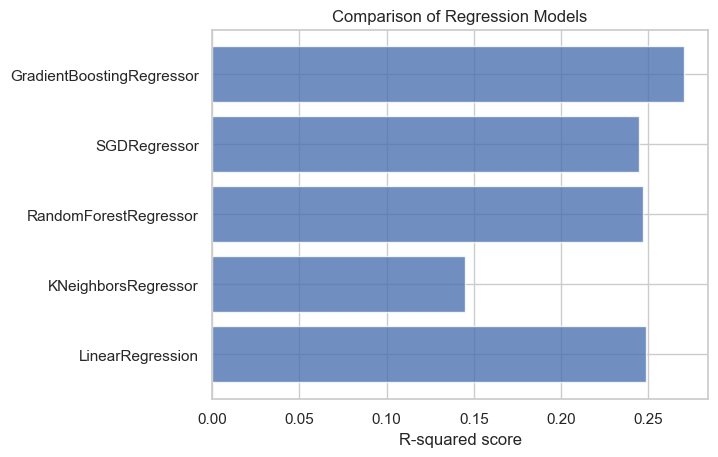

In [103]:
# Printing R2 score results
for k, v in r2_results.items():
    print("R2 score of", k, "is", round(v, 3))

# Visualizing R2 score results
fig, ax = plt.subplots()
ind = range(len(r2_results))
ax.barh(ind, list(r2_results.values()), align='center', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(r2_results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
# fig.savefig('images/compare_models.png', bbox_inches = 'tight')

Mean Cross validation score of LinearRegression is 0.248
Mean Cross validation score of KNeighborsRegressor is 0.121
Mean Cross validation score of RandomForestRegressor is 0.234
Mean Cross validation score of SGDRegressor is 0.241
Mean Cross validation score of GradientBoostingRegressor is 0.261


Text(0.5, 1.0, 'Comparison of Regression Models')

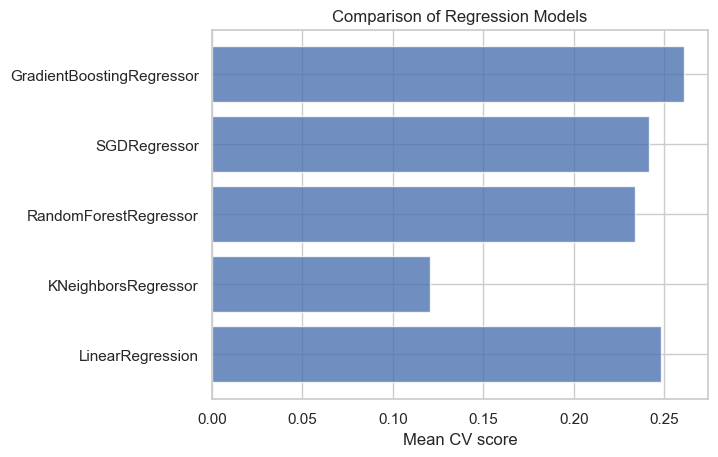

In [104]:
# Printing Cross validation score results
for k, v in cv_results.items():
    print("Mean Cross validation score of", k, "is", round(v, 3))

# Visualizing Cross validation score results
fig, ax = plt.subplots()
ind = range(len(cv_results))
ax.barh(ind, list(cv_results.values()), align='center', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(cv_results.keys())
ax.set_xlabel('Mean CV score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
# fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [105]:
# GradientBoostingRegressor will be used for LOS prediction model
GB_model = GradientBoostingRegressor(random_state=0)   
GB_model.fit(X_train, y_train)
y_test_pred = GB_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_pred)
cv_not_refined = cross_val_score(GB_model, X_test, y_test, cv=5)
print("R2 score is: {:2f}".format(r2_not_refined))
print("Cross validation score is:", cv_not_refined)
print("Mean Cross validation score is: {:2f}".format(cv_not_refined.mean()))

R2 score is: 0.270644
Cross validation score is: [0.2308106  0.29127508 0.24220539 0.24262913 0.2993089 ]
Mean Cross validation score is: 0.261246


# 3.1.1 Regression Model - Hyperparameter Tuning

In [106]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint as sp_randint

# # specify parameters and distributions to sample from
# param_dist = {"max_features": sp_randint(1, X_train.shape[1]),
#               "n_estimators": sp_randint(100, 500),
#               "max_depth": sp_randint(1, 5)}

# gb = GradientBoostingRegressor()

# random_search = RandomizedSearchCV(gb, param_distributions=param_dist,
#                                    n_iter=10, cv=5, random_state=0)

# random_search.fit(X_train, y_train)

In [107]:
# print(random_search.best_params_)

In [108]:
# #Checking the model Using the best params to make predictions against the test data
# y_pred_test = random_search.predict(X_test)

# r2_score(y_test, y_pred_test)

# 3.2 Redifing Lenght-of-Stay (LOS)

**The problem at hand**: Our regression model has a terrible accuracy even after data cleaning (which dealt with missing values as well as outliers). Hyperparameter tuning barely increased the accuracy by 1%. The underlying reasons for this problem are that we are trying to estimate LOS, which is continuous numerical variable, using all categorical variables converted into numerical features using One-Hot Encoding. Regression models perform much better when the input variables are also continuous numerical in nature.

**Solution**: We can convert LOS into a categorical variable through binning LOS in various range of values (eg: low, medium, high). This way instead of predicting the precise LOS, we can change this regression problem into a classification problem of determining the correct bin of LOS. Thus, we don't have to rely on numerical features to tackle this problem.

In [109]:
adm_classification = adm_regression
adm_classification.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48380 entries, 0 to 48379
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LOS                         48380 non-null  float64
 1   D_BLOOD                     48380 non-null  uint8  
 2   D_CIRCULATORY               48380 non-null  uint8  
 3   D_CONGENITAL                48380 non-null  uint8  
 4   D_DIGESTIVE                 48380 non-null  uint8  
 5   D_ENDOCRINE                 48380 non-null  uint8  
 6   D_GENITOURINARY             48380 non-null  uint8  
 7   D_INFECTIOUS                48380 non-null  uint8  
 8   D_INJURY                    48380 non-null  uint8  
 9   D_MENTAL                    48380 non-null  uint8  
 10  D_MISC                      48380 non-null  uint8  
 11  D_MUSCULAR                  48380 non-null  uint8  
 12  D_NEOPLASMS                 48380 non-null  uint8  
 13  D_NERVOUS                   483

In [110]:
adm_classification['LOS'].describe()

count    48380.000000
mean         7.999311
std          6.085626
min          0.014583
25%          3.746354
50%          6.154167
75%         10.601562
max         29.990972
Name: LOS, dtype: float64

In [111]:
# Lets covert age into categorical age groups for simplification of our analysis
LOS_bins = [(0, 4), (4, 7), (7, 11), (11, 30)]
for x, y in enumerate(LOS_bins):
    adm_classification['LOS'] = np.where(adm_classification['LOS'].between(y[0],y[1]), 
            x, adm_classification['LOS'])
    
LOS_dict = {0: 'Low', 1: 'Medium', 2: 'High', 3: 'Very High'}
adm_classification['LOS'] = adm_classification['LOS'].replace(LOS_dict)

In [112]:
adm_classification['LOS'].value_counts()

Low          13790
Medium       13397
Very High    11210
High          9983
Name: LOS, dtype: int64

In [113]:
# Saving the cleaned files
adm_classification.to_csv('admissions_classification.csv', index = False)

# 3.3 Classification Model

In [114]:
# Target Variable (Length-of-Stay) for our prediction model
LOS = adm_classification['LOS'].values

# Feature variables for our prediction model
features = adm_classification.drop(columns=['LOS'])

In [115]:
# Splitting the dataset into 80% training  and 20% testing sets 
X_train, X_test, y_train, y_test = train_test_split(features, LOS, test_size = .20, random_state = 0)

# Printing the results
print("Training set has {} records.".format(X_train.shape[0]))
print("Testing set has {} records.".format(X_test.shape[0]))

Training set has 38704 records.
Testing set has 9676 records.


In [116]:
# Importing Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report

In [117]:
# Baseline Regression models for comparison
models = [GaussianNB(),
          KNeighborsClassifier(),
          DecisionTreeClassifier(random_state=0),
          RandomForestClassifier(n_estimators=10, random_state=0),
          SGDClassifier(random_state = 0), 
          GradientBoostingClassifier(random_state = 0)]

accuracy = {}
cm = {}
cr = {}

for model in models:
    # Fitting training data into the Regression models
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Prediction from the model
    y_test_pred = reg_model.predict(X_test)
    
    # Storing the model name in a variable
    name = str(model).split("(")[0]
    
    # Accuracy score of the model
    accuracy[name] = accuracy_score(y_test, y_test_pred)
    
    # Confusion Matrix of the model
    cm[name] = confusion_matrix(y_test, y_test_pred)
    
    # Confusion_Matrix of the model
    cr[name] = classification_report(y_test, y_test_pred)
    
    print('{} done.'.format(name))

GaussianNB done.
KNeighborsClassifier done.
DecisionTreeClassifier done.
RandomForestClassifier done.
SGDClassifier done.
GradientBoostingClassifier done.


Accuracy of GaussianNB is 0.369
Accuracy of KNeighborsClassifier is 0.378
Accuracy of DecisionTreeClassifier is 0.365
Accuracy of RandomForestClassifier is 0.394
Accuracy of SGDClassifier is 0.415
Accuracy of GradientBoostingClassifier is 0.44


Text(0.5, 1.0, 'Comparison of Classification Models')

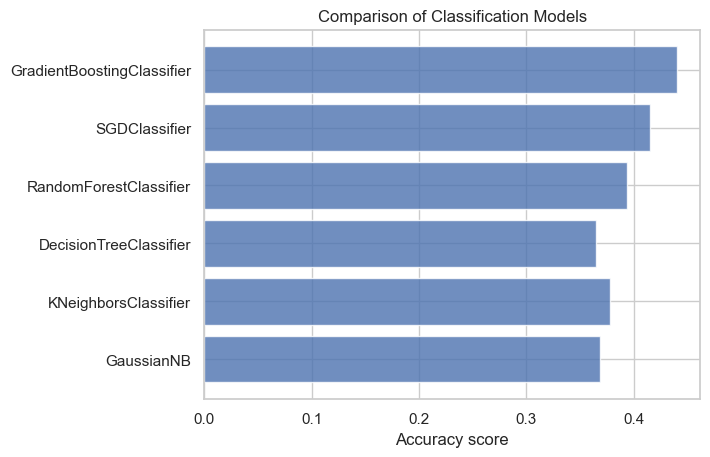

In [118]:
# Printing Accuracy score results
for k, v in accuracy.items():
    print("Accuracy of", k, "is", round(v, 3))

# Plotting Accuracy score results
fig, ax = plt.subplots()
ind = range(len(accuracy))
ax.barh(ind, list(accuracy.values()), align='center', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(accuracy.keys())
ax.set_xlabel('Accuracy score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Classification Models')
# fig.savefig('images/compare_models.png', bbox_inches = 'tight')

Out of all the classifiers, clearly **Gradient Boosting Classifier** is performing the best. For further model refinement, we will be using Gradient Boosting Classifier.

In [119]:
print("Confusion Matrix for Gradient Boosting Classifier: \n", cm['GradientBoostingClassifier'])

Confusion Matrix for Gradient Boosting Classifier: 
 [[ 158  418  776  656]
 [  71 1815  681  270]
 [ 121  950 1058  483]
 [ 147  319  526 1227]]


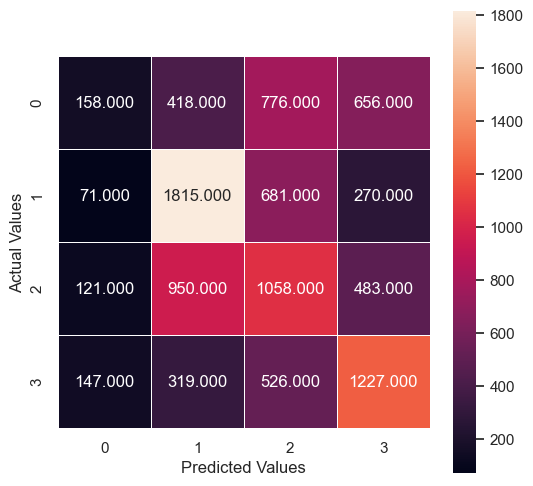

In [120]:
# Plotting the Confusion matrix for GradientBoostingRegressor
plt.figure(figsize=(6, 6))
sns.heatmap(cm['GradientBoostingClassifier'], annot=True, fmt='0.3f', linewidth=0.5, 
           square=True, cbar=True)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [121]:
print("Classification Report for Gradient Boosting Classifier: \n", cr['GradientBoostingClassifier'])

Classification Report for Gradient Boosting Classifier: 
               precision    recall  f1-score   support

        High       0.32      0.08      0.13      2008
         Low       0.52      0.64      0.57      2837
      Medium       0.35      0.41      0.37      2612
   Very High       0.47      0.55      0.51      2219

    accuracy                           0.44      9676
   macro avg       0.41      0.42      0.39      9676
weighted avg       0.42      0.44      0.41      9676



In [122]:
# GradientBoostingRegressor will be used for LOS prediction model
GB_model = GradientBoostingClassifier(random_state=0)   
GB_model.fit(X_train, y_train)
y_test_pred = GB_model.predict(X_test)
accuracy_not_refined = accuracy_score(y_test, y_test_pred)
print("Accuracy score is: {:2f}".format(accuracy_not_refined))

Accuracy score is: 0.440058


# 3.3.1 Classification Model - Hyperparameter Tuning

In [145]:
print(GB_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [123]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# specify parameters and distributions to sample from
param_dist = {"max_features": sp_randint(1, X_train.shape[1]),
              "n_estimators": sp_randint(0, 200),
              "max_depth": sp_randint(1, 5)}

gb = GradientBoostingClassifier()

random_search = RandomizedSearchCV(gb, param_distributions=param_dist,
                                   n_iter=10, cv=5, random_state=0)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017D91403490>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017D90FEBB50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017D91E9A940>},
                   random_state=0)

In [124]:
print(random_search.best_params_)

{'max_depth': 4, 'max_features': 47, 'n_estimators': 188}


In [125]:
#Checking the model Using the best params to make predictions against the test data
y_pred_test = random_search.predict(X_test)

accuracy_score(y_test, y_pred_test)

0.444398511781728

# 4. Auto ML (using PyCaret)

**Binary Classification of LOS**: Before using Auto-ML, Let's change our LOS to just 'high' and 'low' catergories based on median and use Auto-ML library (PyCaret) to predict LOS.

In [103]:
# Putting admissions data in a seperate dataframe before model implementation
adm_pycaret = admissions_cleaned
adm_pycaret.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48380 entries, 0 to 48379
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ADMISSION_TYPE   48380 non-null  object 
 1   INSURANCE        48380 non-null  object 
 2   RELIGION         48380 non-null  object 
 3   MARITAL_STATUS   48380 non-null  object 
 4   ETHNICITY        48380 non-null  object 
 5   LOS              48380 non-null  float64
 6   D_BLOOD          48380 non-null  uint8  
 7   D_CIRCULATORY    48380 non-null  uint8  
 8   D_CONGENITAL     48380 non-null  uint8  
 9   D_DIGESTIVE      48380 non-null  uint8  
 10  D_ENDOCRINE      48380 non-null  uint8  
 11  D_GENITOURINARY  48380 non-null  uint8  
 12  D_INFECTIOUS     48380 non-null  uint8  
 13  D_INJURY         48380 non-null  uint8  
 14  D_MENTAL         48380 non-null  uint8  
 15  D_MISC           48380 non-null  uint8  
 16  D_MUSCULAR       48380 non-null  uint8  
 17  D_NEOPLASMS 

In [104]:
adm_pycaret['LOS'].describe()

count    48380.000000
mean         7.999311
std          6.085626
min          0.014583
25%          3.746354
50%          6.154167
75%         10.601562
max         29.990972
Name: LOS, dtype: float64

In [105]:
# Lets covert age into categorical age groups for simplification of our analysis
LOS_bins = [(0, 7),(7, 30)]
for x, y in enumerate(LOS_bins):
    adm_pycaret['LOS'] = np.where(adm_pycaret['LOS'].between(y[0],y[1]), 
            x, adm_pycaret['LOS'])
    
LOS_dict = {0: 'Low', 1: 'High'}
adm_pycaret['LOS'] = adm_pycaret['LOS'].replace(LOS_dict)

In [106]:
adm_pycaret['LOS'].value_counts()

Low     27187
High    21193
Name: LOS, dtype: int64

In [107]:
adm_pycaret.columns

Index(['ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'LOS', 'D_BLOOD', 'D_CIRCULATORY', 'D_CONGENITAL',
       'D_DIGESTIVE', 'D_ENDOCRINE', 'D_GENITOURINARY', 'D_INFECTIOUS',
       'D_INJURY', 'D_MENTAL', 'D_MISC', 'D_MUSCULAR', 'D_NEOPLASMS',
       'D_NERVOUS', 'D_PREGNANCY', 'D_PRENATAL', 'D_RESPIRATORY', 'D_SKIN',
       'GENDER', 'age', 'ICU', 'NICU'],
      dtype='object')

# 4.1. Binary Classification

In [101]:
from pycaret.classification import *

In [108]:
clf = setup(data=adm_pycaret, target='LOS', session_id=1,
            group_features = [['D_BLOOD', 'D_CIRCULATORY', 'D_CONGENITAL', 'D_DIGESTIVE', 'D_ENDOCRINE', 
                              'D_GENITOURINARY', 'D_INFECTIOUS', 'D_INJURY', 'D_MENTAL', 'D_MISC', 
                              'D_MUSCULAR', 'D_NEOPLASMS', 'D_NERVOUS', 'D_PREGNANCY', 'D_PRENATAL',
                              'D_RESPIRATORY', 'D_SKIN']],
            feature_selection = True, feature_selection_threshold=0.8)

,Description,Value
0,session_id,1
1,Target,LOS
2,Target Type,Binary
3,Label Encoded,"High: 0, Low: 1"
4,Original Data,"(48380, 27)"
5,Missing Values,False
6,Numeric Features,19
7,Categorical Features,7
8,Ordinal Features,False
9,High Cardinality Features,False


In [109]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7045,0.7783,0.7622,0.7250,0.7431,0.3958,0.3965,0.1140
gbc,Gradient Boosting Classifier,0.6998,0.7747,0.7511,0.7240,0.7373,0.3874,0.3877,0.9470
ada,Ada Boost Classifier,0.6936,0.7653,0.7463,0.7184,0.7320,0.3746,0.3751,0.3840
rf,Random Forest Classifier,0.6889,0.7593,0.7241,0.7219,0.7230,0.3681,0.3682,0.8000
lda,Linear Discriminant Analysis,0.6886,0.7621,0.7903,0.6958,0.7400,0.3558,0.3604,0.1720
ridge,Ridge Classifier,0.6884,0.0000,0.7909,0.6953,0.7400,0.3551,0.3597,0.0470
lr,Logistic Regression,0.6878,0.7607,0.7770,0.6995,0.7362,0.3563,0.3593,1.5060
et,Extra Trees Classifier,0.6809,0.7483,0.7160,0.7153,0.7157,0.3522,0.3522,1.1180
svm,SVM - Linear Kernel,0.6736,0.0000,0.7853,0.6900,0.7271,0.3218,0.3399,0.1410
knn,K Neighbors Classifier,0.6565,0.7081,0.7551,0.6727,0.7115,0.2907,0.2937,1.7740


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [110]:
# Lets look at the best model
best = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7107,0.7853,0.7605,0.7335,0.7468,0.4096,0.4099
1,0.7012,0.7787,0.7674,0.7189,0.7424,0.3877,0.3888
2,0.6950,0.7682,0.7530,0.7172,0.7347,0.3766,0.3772
3,0.7009,0.7754,0.7530,0.7244,0.7384,0.3896,0.3900
4,0.7124,0.7901,0.7730,0.7300,0.7509,0.4115,0.4124
5,0.7129,0.7869,0.7794,0.7280,0.7528,0.4115,0.4129
6,0.6988,0.7717,0.7599,0.7190,0.7389,0.3836,0.3844
7,0.7067,0.7716,0.7672,0.7256,0.7458,0.3999,0.4008
8,0.7032,0.7781,0.7525,0.7276,0.7398,0.3946,0.3949


In [111]:
print(best)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


# 4.2. Hyperparameter Tuning

In [112]:
best_hypertuned = tune_model(best, optimize='Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7080,0.7821,0.7616,0.7297,0.7453,0.4036,0.4041
1,0.6980,0.7787,0.7658,0.7157,0.7399,0.3808,0.3820
2,0.6912,0.7645,0.7514,0.7131,0.7318,0.3684,0.3691
3,0.6977,0.7723,0.7472,0.7229,0.7349,0.3834,0.3837
4,0.7110,0.7878,0.7757,0.7270,0.7506,0.4078,0.4090
5,0.7118,0.7840,0.7757,0.7281,0.7511,0.4095,0.4107
6,0.6958,0.7684,0.7593,0.7156,0.7368,0.3772,0.3781
7,0.6988,0.7689,0.7572,0.7201,0.7382,0.3841,0.3847
8,0.7085,0.7776,0.7530,0.7341,0.7434,0.4061,0.4063


In [141]:
print(best_hypertuned)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, device='gpu',
               feature_fraction=0.6, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=100, min_child_weight=0.001,
               min_split_gain=0.6, n_estimators=280, n_jobs=-1, num_leaves=70,
               objective=None, random_state=1, reg_alpha=0.1, reg_lambda=0.001,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


# 4.3. Ensemble Model

In [142]:
best_bagged = ensemble_model(best, method='Bagging')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7115,0.7864,0.7658,0.7323,0.7486,0.4106,0.4112
1,0.7056,0.7825,0.7721,0.7223,0.7464,0.3966,0.3979
2,0.6962,0.7706,0.7509,0.7195,0.7349,0.3796,0.3800
3,0.6980,0.7758,0.7509,0.7217,0.7360,0.3834,0.3839
4,0.7053,0.7906,0.7678,0.7236,0.7450,0.3968,0.3978
5,0.7106,0.7879,0.7757,0.7267,0.7504,0.4069,0.4081
6,0.6996,0.7723,0.7599,0.7201,0.7394,0.3856,0.3863
7,0.7073,0.7753,0.7620,0.7286,0.7449,0.4021,0.4026
8,0.7115,0.7812,0.7599,0.7347,0.7471,0.4115,0.4118


In [143]:
best_boosted = ensemble_model(best, method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7030,0.7768,0.7521,0.7276,0.7396,0.3942,0.3945
1,0.6932,0.7684,0.7637,0.7109,0.7364,0.3707,0.3721
2,0.6921,0.7590,0.7551,0.7127,0.7333,0.3697,0.3706
3,0.6897,0.7645,0.7383,0.7168,0.7274,0.3675,0.3677
4,0.7036,0.7768,0.7583,0.7254,0.7415,0.3945,0.3950
5,0.7056,0.7736,0.7636,0.7257,0.7442,0.3979,0.3986
6,0.6878,0.7564,0.7504,0.7097,0.7295,0.3612,0.3620
7,0.6923,0.7655,0.7578,0.7120,0.7342,0.3697,0.3707
8,0.6955,0.7676,0.7472,0.7203,0.7335,0.3787,0.3790


# 4.4. Evaluate Model

In [113]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…